In [1]:
#learning classification
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.ToTensor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Load test dataset
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [12]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check dataset size
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Class names for FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Training samples: 60000
Test samples: 10000


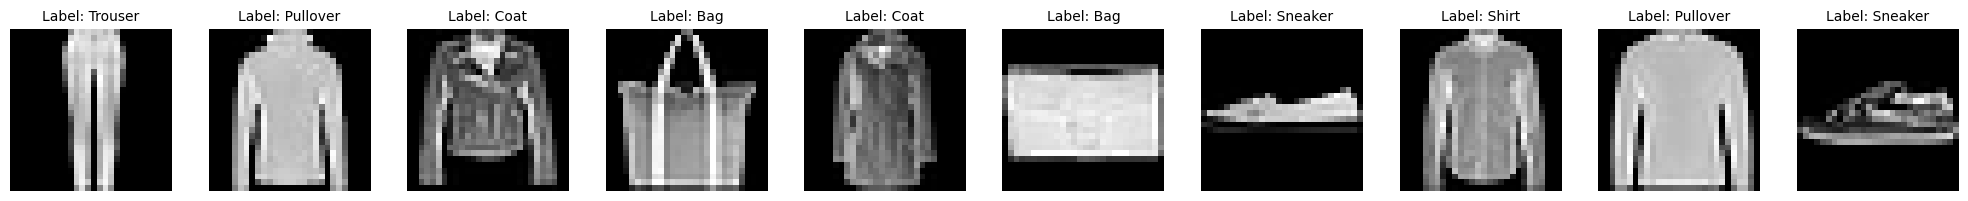

In [13]:
def show_images(images, labels, predictions=None):
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap='gray')
        true_label = class_names[labels[i]]
        if predictions is not None:
            pred_label = class_names[predictions[i]]
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
        else:
            ax.set_title(f"Label: {true_label}", fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show first 10 images
show_images(images[:10], labels[:10])

In [18]:
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # After two maxpool layers: 28/2/2 = 7
        self.fc2 = nn.Linear(128, 10)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Create model instance
model = FashionMNISTModel().to(device)
print(model)

FashionMNISTModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [20]:
# Loss function (CrossEntropyLoss combines LogSoftmax and NLLLoss)
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [21]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Print progress every 100 batches
        if batch_idx % 100 == 99:
            print(f'Batch: {batch_idx + 1}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

In [22]:
def test_epoch(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradients needed for evaluation
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

In [23]:
# Training parameters
num_epochs = 10
train_losses, train_accs = [], []
test_losses, test_accs = [], []

print("Starting training...")
print("="*50)

for epoch in range(num_epochs):
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Testing phase
    test_loss, test_acc = test_epoch(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Update learning rate
    scheduler.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    print("-"*50)

print("Training completed!")

Starting training...
Batch: 100, Loss: 0.6651
Batch: 200, Loss: 0.3687
Batch: 300, Loss: 0.5368
Batch: 400, Loss: 0.6099
Batch: 500, Loss: 0.4386
Batch: 600, Loss: 0.3184
Batch: 700, Loss: 0.4520
Batch: 800, Loss: 0.4515
Batch: 900, Loss: 0.3308
Epoch 1/10:
Train Loss: 0.4859, Train Acc: 82.21%
Test Loss: 0.3489, Test Acc: 87.17%
--------------------------------------------------
Batch: 100, Loss: 0.4002
Batch: 200, Loss: 0.2955
Batch: 300, Loss: 0.3748
Batch: 400, Loss: 0.4485
Batch: 500, Loss: 0.4010
Batch: 600, Loss: 0.4037
Batch: 700, Loss: 0.2083
Batch: 800, Loss: 0.2433
Batch: 900, Loss: 0.2143
Epoch 2/10:
Train Loss: 0.3147, Train Acc: 88.48%
Test Loss: 0.2832, Test Acc: 89.61%
--------------------------------------------------
Batch: 100, Loss: 0.2484
Batch: 200, Loss: 0.1949
Batch: 300, Loss: 0.1506
Batch: 400, Loss: 0.2717
Batch: 500, Loss: 0.2177
Batch: 600, Loss: 0.3972
Batch: 700, Loss: 0.2311
Batch: 800, Loss: 0.1945
Batch: 900, Loss: 0.2391
Epoch 3/10:
Train Loss: 0.2670

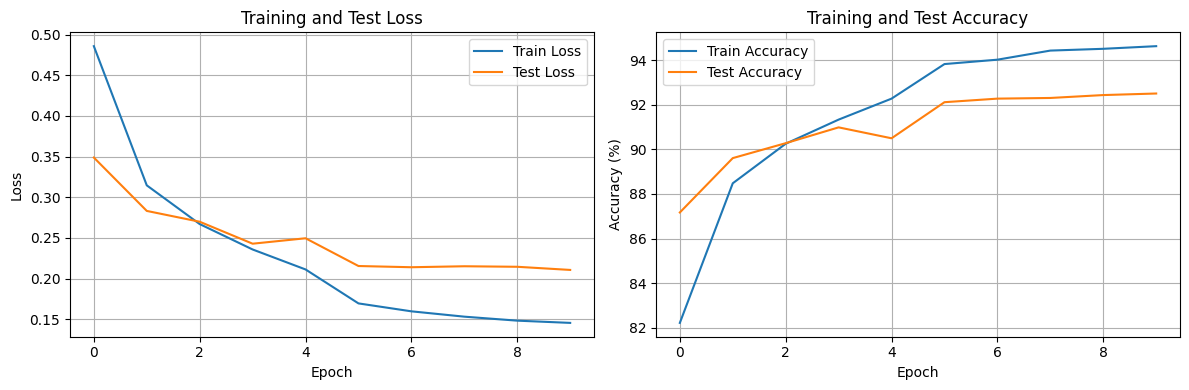

In [24]:
# Plot loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(test_accs, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

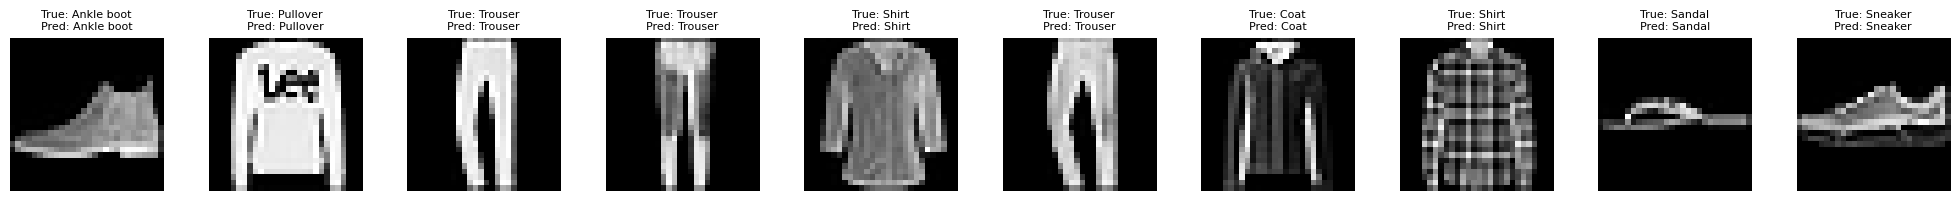

Batch accuracy: 92.19%


In [25]:
# Get some test samples
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predictions = outputs.max(1)

# Move back to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predictions = predictions.cpu()

# Show predictions
show_images(images[:10], labels[:10], predictions[:10])

# Calculate accuracy for this batch
correct = predictions.eq(labels).sum().item()
total = labels.size(0)
print(f'Batch accuracy: {100. * correct / total:.2f}%')

In [26]:
# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'fashion_mnist_model.pth')

print("Model saved to fashion_mnist_model.pth")

# Load the model (for later use)
def load_model(model_path):
    checkpoint = torch.load(model_path)
    model = FashionMNISTModel().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

# loaded_model = load_model('fashion_mnist_model.pth')

Model saved to fashion_mnist_model.pth
